In [16]:
import os
import sys
import numpy as np
import pandas as pd
import json
from tqdm import tqdm
from pprint import pprint
import torch
sys.path.append('..')
sys.path.append('/home/valerie/Projects/Alps_LCC/models')
print(sys.path)

import torch
from torchvision.models import resnet50
import matplotlib.pyplot as plt
from models.ACE_Better_DeepLabV3Plus import ACE_deeplabv3P_w_Better_Experts
from argparse import Namespace
from dataset.SwissImageDataset import SwissImage
from torch.utils.data import DataLoader
torch.set_grad_enabled(False) 
from torch.nn.functional import softmax


['/home/valerie/Projects/Alps_LCC/notebook', '/home/valerie/anaconda3/envs/ace/lib/python311.zip', '/home/valerie/anaconda3/envs/ace/lib/python3.11', '/home/valerie/anaconda3/envs/ace/lib/python3.11/lib-dynload', '', '/home/valerie/anaconda3/envs/ace/lib/python3.11/site-packages', '..', '/home/valerie/Projects/Alps_LCC/models', '.', '.', 'models/', '.', '..', '..', '/home/valerie/Projects/Alps_LCC/models']


In [17]:
classes = {'Background':0, "Bedrock" : 1, "Bedrockwith grass" : 2,
                    "Large blocks" : 3, "Large blocks with grass" : 4, "Scree" : 5,
                    "Scree with grass" : 6,"Water" : 7,
                    "Forest" : 8, "Glacier" : 9, }  

In [18]:
config_fp ='/home/valerie/Projects/Alps_LCC/out/experts/ace_3exp_30June/config.json'
checkpoint_path = '/home/valerie/Projects/Alps_LCC/out/experts/ace_3exp_30June/current_best.pt'
# Open the JSON file and load its contents as a dictionary
with open(config_fp, 'r') as json_file:
    cfg = json.load(json_file)
    args = Namespace(**cfg)
    pprint(cfg)
checkpoint = torch.load(checkpoint_path)
pprint(checkpoint.keys())

{'CNN_aggregator': False,
 'L2penalty': False,
 'MLP_aggregator': False,
 'bs': 64,
 'debug': False,
 'device': 'cuda',
 'epoch': 50,
 'experts': 3,
 'force_cpu': False,
 'log_wandb': True,
 'loss': 'celoss',
 'lr': 1e-05,
 'lr_decay_rate': 0.1,
 'lws': False,
 'model': 'Deeplabv3_w_Better_Experts',
 'name': 'ace_3exp_30June',
 'num_workers': 16,
 'out_dir': 'out/baseline/',
 'seed': 2436,
 'separate_backprop': False,
 'small_dataset': True,
 'step_size': 10,
 'test_only': False,
 'weight_decay': 0.01}


dict_keys(['epoch', 'state_dict', 'perf', 'last_epoch', 'optimizer'])


In [19]:
model = ACE_deeplabv3P_w_Better_Experts(num_classes=10,num_experts=args.experts, pretrained_backbone=True,use_lws=True,)
model.load_state_dict(checkpoint['state_dict'])
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device
model = model.to(device)

In [24]:
img_dir = '/home/valerie/data/rocky_tlm/rgb/' 
dem_dir = '/home/valerie/data/rocky_tlm/dem/' 
mask_dir = '/home/valerie/data/ace_alps/mask' 
test_csv = '/home/valerie/Projects/Alps_LCC/data/split/test_dataset.csv'


test_dataset = SwissImage(
    dataset_csv = test_csv,
    img_dir = img_dir,
    dem_dir = dem_dir,
    mask_dir = mask_dir,
    common_transform=None,
    img_transform= None,
    debug= False,          
)
test_loader = DataLoader(test_dataset, 
    batch_size= 64,
    shuffle=False,
    num_workers= 8,
    pin_memory=True
)



In [25]:
from utils.inference_utils import MetricLogger
metrics_0 = MetricLogger( n_classes=10)
metrics_1 = MetricLogger( n_classes=10)
metrics_2 = MetricLogger(10)

for i, (image, dem, mask) in tqdm(enumerate(test_loader)):
    
    # move data to device
    input = torch.cat((image, dem), dim=1).to(device) 
    mask = mask.to(device) 
    num_inputs = input.size(0)
    
    # Run forwards pass and compute loss : 
    output = model(input) 
    
    exp_0_logits =  softmax( output['exp_0'],dim=1)
    preds_0 = torch.argmax(exp_0_logits.detach().cpu(),axis=1) 
    exp_1_logits =  softmax(output['exp_1'], dim=1 )  
    preds_1 = torch.argmax(exp_1_logits.detach().cpu(),axis=1) 
    exp_2_logits= softmax( output['exp_2'],dim=1)
    preds_2 = torch.argmax(exp_2_logits.detach().cpu(),axis=1) 
    
    gt = mask.squeeze().detach().cpu().numpy()
    metrics_0.update(gt, preds_0.numpy())
    metrics_1.update(gt, preds_1.numpy())
    metrics_2.update(gt, preds_2.numpy())

718it [10:54,  1.10it/s]


In [26]:
mean_acc, mean_iou, acc_cls, overall_acc = metrics_0.get_scores()
print('mean_acc, mean_iou, overall_acc ')
print('expert 0' )
class_accuracies = { cls : np.round (value,3) for cls, value in zip (classes.keys(),acc_cls )  }     
freq_cls_acc =   1/4* (class_accuracies["Scree"]+ class_accuracies["Bedrock"] + class_accuracies["Glacier"] + class_accuracies["Forest"])
common_cls_acc = 1/3* (class_accuracies["Scree with grass"]+    class_accuracies["Water"]+   class_accuracies["Bedrockwith grass"])
rare_cls_acc =   1/2* (class_accuracies["Large blocks"]+   class_accuracies["Large blocks with grass"]) 
metrics0 = {
            'test_miou' : np.round ( mean_iou,3), 
            'test_macc':  np.round (mean_acc,3), 
            'test_oacc':  np.round (overall_acc,3),
            'frequent_cls_acc':np.round(freq_cls_acc,3),
            'common_cls_acc': np.round(common_cls_acc,3),
            'rare_cls_acc': np.round(rare_cls_acc,3),
            'test_acc' :  class_accuracies,
    }
pprint(metrics0)
#
mean_acc, mean_iou, acc_cls, overall_acc = metrics_1.get_scores()
print('expert 1' )
class_accuracies = { cls : np.round (value,3) for cls, value in zip (classes.keys(),acc_cls )  }
freq_cls_acc =   1/4* (class_accuracies["Scree"]+ class_accuracies["Bedrock"] + class_accuracies["Glacier"] + class_accuracies["Forest"])
common_cls_acc = 1/3* (class_accuracies["Scree with grass"]+    class_accuracies["Water"]+   class_accuracies["Bedrockwith grass"])
rare_cls_acc =   1/2* (class_accuracies["Large blocks"]+   class_accuracies["Large blocks with grass"])
metrics1 = {
            'test_miou' : np.round ( mean_iou,3), 
            'test_macc':  np.round (mean_acc,3), 
            'test_oacc':  np.round (overall_acc,3),
            'frequent_cls_acc':np.round(freq_cls_acc,3),
            'common_cls_acc': np.round(common_cls_acc,3),
            'rare_cls_acc': np.round(rare_cls_acc,3),
            'test_acc' :  class_accuracies,
    }
pprint(metrics1)
mean_acc, mean_iou, acc_cls, overall_acc = metrics_2.get_scores()
#
print('expert 2' )
class_accuracies = { cls : np.round (value,3) for cls, value in zip (classes.keys(),acc_cls )  }
freq_cls_acc =   1/4* (class_accuracies["Scree"]+ class_accuracies["Bedrock"] + class_accuracies["Glacier"] + class_accuracies["Forest"])
common_cls_acc = 1/3* (class_accuracies["Scree with grass"]+    class_accuracies["Water"]+   class_accuracies["Bedrockwith grass"])
rare_cls_acc =   1/2* (class_accuracies["Large blocks"]+   class_accuracies["Large blocks with grass"])
metrics2 = {
            'test_miou' : np.round ( mean_iou,3), 
            'test_macc':  np.round (mean_acc,3), 
            'test_oacc':  np.round (overall_acc,3),
            'frequent_cls_acc':np.round(freq_cls_acc,3),
            'common_cls_acc': np.round(common_cls_acc,3),
            'rare_cls_acc': np.round(rare_cls_acc,3),
            'test_acc' :  class_accuracies,
    }
pprint(metrics2)


mean_acc, mean_iou, overall_acc 
expert 0
{'common_cls_acc': 0.475,
 'frequent_cls_acc': 0.865,
 'rare_cls_acc': 0.134,
 'test_acc': {'Background': 0.0,
              'Bedrock': 0.799,
              'Bedrockwith grass': 0.144,
              'Forest': 0.956,
              'Glacier': 0.892,
              'Large blocks': 0.231,
              'Large blocks with grass': 0.038,
              'Scree': 0.815,
              'Scree with grass': 0.386,
              'Water': 0.894},
 'test_macc': 0.516,
 'test_miou': 0.448,
 'test_oacc': 0.833}
expert 1
{'common_cls_acc': 0.852,
 'frequent_cls_acc': 0.048,
 'rare_cls_acc': 0.472,
 'test_acc': {'Background': 0.013,
              'Bedrock': 0.002,
              'Bedrockwith grass': 0.696,
              'Forest': 0.084,
              'Glacier': 0.099,
              'Large blocks': 0.873,
              'Large blocks with grass': 0.072,
              'Scree': 0.008,
              'Scree with grass': 0.888,
              'Water': 0.973},
 'test_macc': 

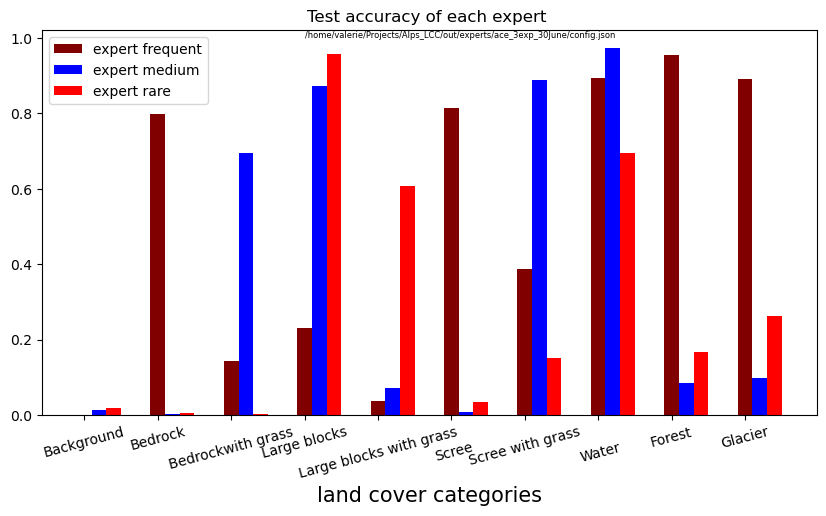

In [30]:
v_0 = list(metrics0['test_acc'].values())
v_1 = list(metrics1['test_acc'].values())
v_2 = list(metrics2['test_acc'].values())


fig = plt.figure(figsize = (10, 5))
# Set position of bar on X axis
barWidth =0.2
br1 = np.arange(len(v_0))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

# creating the bar plot
plt.bar(br1,v_0, color ='maroon',  width = barWidth, label ='expert frequent' )
plt.bar(br2,v_1, color ='blue',  width = barWidth , label ='expert medium')
plt.bar(br3,v_2, color ='red',  width = barWidth, label ='expert rare' )
plt.title('Test accuracy of each expert ')
plt.xlabel('land cover categories',  fontsize = 15)
plt.xticks(range(10),['Background', "Bedrock", "Bedrockwith grass", "Large blocks", "Large blocks with grass", "\nScree",  "Scree with grass","\nWater", "Forest" , "Glacier" ,],rotation =15)
plt.text(x=3,y=1,s=config_fp,fontsize = 6)
plt.legend()
plt.show()

In [ ]:
v_0

[0.242,
 0.316,
 0.664,
 0.69,
 0.027,
 nan,
 {'Background': 0.0,
  'Bedrock': 0.634,
  'Bedrockwith grass': 0.0,
  'Large blocks': 0.002,
  'Large blocks with grass': nan,
  'Scree': 0.663,
  'Scree with grass': 0.051,
  'Water': 0.03,
  'Forest': 0.695,
  'Glacier': 0.768}]